# A notebook to visualise certain terms that appear in the paper

In [1]:
import torch
import numpy as np
from  torch.distributions import multivariate_normal
import signatory
import matplotlib.pyplot as plt
# import pandas as pd
import os, sys
os.chdir("..")
from src.utils import *
from src.simulators import *
from src.sig_trader import *

In [2]:
import sigkernel
from src.kernel_compute import KernelCompute
from src.kernel_trader_lean import KernelTrader
from src.sig_trader import SigTrader

if torch.cuda.is_available(): 
  device = 'cuda'
else: 
  device = 'cpu'

print('device:', device)

device: cuda


In [3]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib import rc
from matplotlib.colors import ListedColormap
import seaborn as sns

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
plt.rcParams.update({
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsfonts}'
})

cmap = ListedColormap([sns.color_palette("Blues")[5], 'lightskyblue', sns.color_palette("rocket")[3],sns.color_palette("rocket")[2]])
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", cmap.colors)

# Simulate Asset

In [4]:
torch.manual_seed(8)

paths = generate_OU_paths(
    n_samples=1000, 
    n_days=50,
    dt=1, 
    dim=1, 
    S_0=0,
    theta=0.01,
    sigma=0.03, 
    mu=0)+1

### Asset Paths

In [5]:
sample_length = 700 # sample split

# Asset Paths
asset_sample_data = paths[:sample_length]
asset_oos_data = paths[sample_length:]

# sample_path_rets = torch.diff(sp.asset_paths[:sample_length,:280])
path_rets = torch.diff(asset_sample_data,dim=1)
# sample_signal = sp.factor_paths[:sample_length,20:299]

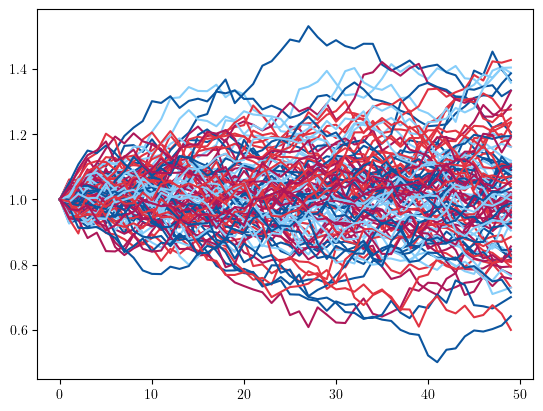

In [6]:
plt.plot(asset_sample_data[:100,:,0].T);

# Sig Kernel Trader

In [7]:
class SigKer(KernelCompute):
    def __init__(self):
        self.dyadic_order = 0
        self.Kernel_Class = sigkernel.SigKernel(sigkernel.LinearKernel(), dyadic_order=self.dyadic_order)
        self.scale = 2
        
    def compute_Gram(self, X, Y, sym=False):
        return self.Kernel_Class.compute_Gram(self.scale*X.double(),self.scale*Y.double(), sym=sym)[..., ::2**self.dyadic_order, ::2**self.dyadic_order]
    
    def K_Phi(self, X, time_augmented=False, max_batch=50):
        return super().K_Phi(X, time_augmented, max_batch)

In [8]:
# Hard Code if necessary

device = "cpu"

In [9]:
Ker = SigKer()
SKT = KernelTrader(Ker,
                        device, time_augment=True)

SKT.pre_fit(asset_sample_data)

In [10]:
SKT.fit(risk_aversion=0.5, regularisation=1e-5*SKT.Xi.norm())
SKT.compute_pnl(asset_sample_data)

## Observing Terms

### Gram Matrix

- $N \times N$ in size for 

$$
K(X_i, X_j)
$$

In [11]:
SKT.K_Phi.shape

torch.Size([700, 700])

### $\alpha^*$ as a set of weights

\begin{align*}
\alpha^* = & \frac{N-1}{2\lambda} 
        \left[ (K - \mathbf{1}\mathbf{1}^T)\left(
     Id -  \frac{1}{N}\mathbf{1}\mathbf{1}^T
    \right)(K - \mathbf{1}\mathbf{1}^T)\right]^{-1} (K - \mathbf{1}\mathbf{1}^T)\mathbf{1} \\
    = & \frac{N-1}{2\lambda} \left[ \left(
     Id -  \frac{1}{N}\mathbf{1}\mathbf{1}^T 
    \right) (K - \mathbf{1}\mathbf{1}^T) \right]^{-1}\mathbf{1}

\end{align*}

In [12]:
SKT.alpha.shape

torch.Size([700])

### $\phi^*(\cdot)$ for test set

$$
    \phi^*(y) 
    = \int \alpha^*(x) \Gamma_{1,1}(y,x) d\mu_{\mathcal{X}}(x)
$$
where $\alpha^*(x^i) = \alpha_i^*$.

In [13]:
# [in sample batch size, OOS batch size, length of path, dim]
SKT.Phi.shape

torch.Size([700, 700, 50, 1])

### $\Xi = \langle \eta_X, \eta_Y \rangle = \frac{1}{N}(K - \mathbf{11}^\top)$ 

When does this equality hold?

In [14]:
SKT.Xi.shape

torch.Size([700, 700])

#### Compute Gram Matrix

In [16]:
# Compute gram matrix of sample paths K: [batch_x, batch_x]
scale = 2
dyadic_order = 0
sym = False
max_batch = 50
X = asset_sample_data.clone()
Y = asset_sample_data.clone()

static_kernel = sigkernel.LinearKernel()
signature_kernel = sigkernel.SigKernel(static_kernel, 0)

G = signature_kernel.compute_Gram(scale*X.double(),scale*Y.double(), sym=sym)[..., ::2**dyadic_order, ::2**dyadic_order]
# K = signature_kernel.compute_Gram(asset_sample_data, asset_sample_data,
#                                     sym=True, max_batch=max_batch)

In [31]:
SKT.Xi

tensor([[ 4.0607e-05,  1.0305e-05,  3.5916e-05,  ...,  4.1375e-05,
         -9.5491e-05, -1.9882e-05],
        [ 1.0305e-05,  3.0138e-04, -2.7301e-04,  ..., -1.6886e-04,
          4.1881e-04, -1.8119e-04],
        [ 3.5916e-05, -2.7301e-04,  3.9713e-04,  ...,  2.4980e-04,
         -6.0109e-04,  1.6368e-04],
        ...,
        [ 4.1375e-05, -1.6886e-04,  2.4980e-04,  ...,  1.7726e-04,
         -4.3008e-04,  9.0728e-05],
        [-9.5491e-05,  4.1881e-04, -6.0109e-04,  ..., -4.3008e-04,
          1.1938e-03, -2.5420e-04],
        [-1.9882e-05, -1.8119e-04,  1.6368e-04,  ...,  9.0728e-05,
         -2.5420e-04,  1.3820e-04]], dtype=torch.float64)

In [19]:
G.shape

torch.Size([700, 700, 50, 50])

In [27]:
N = G.shape[0]
Xi_manual = (1/N)*(G[:,:,-1,-1]-torch.ones(N,N))
print(Xi_manual)

tensor([[ 4.8303e-05,  2.1023e-04, -1.3775e-04,  ..., -7.3186e-05,
          1.8818e-04, -1.3061e-04],
        [ 2.1023e-04,  9.9730e-04, -5.3811e-04,  ..., -2.9712e-04,
          8.8256e-04, -5.1254e-04],
        [-1.3775e-04, -5.3811e-04,  4.4725e-04,  ...,  2.2695e-04,
         -4.8863e-04,  4.2203e-04],
        ...,
        [-7.3186e-05, -2.9712e-04,  2.2695e-04,  ...,  1.1705e-04,
         -2.6841e-04,  2.1452e-04],
        [ 1.8818e-04,  8.8256e-04, -4.8863e-04,  ..., -2.6841e-04,
          7.8224e-04, -4.6515e-04],
        [-1.3061e-04, -5.1254e-04,  4.2203e-04,  ...,  2.1452e-04,
         -4.6515e-04,  3.9824e-04]], dtype=torch.float64)


Can we show that $K-\mathbf{11}^\top$ is even a function of `K_phi`?

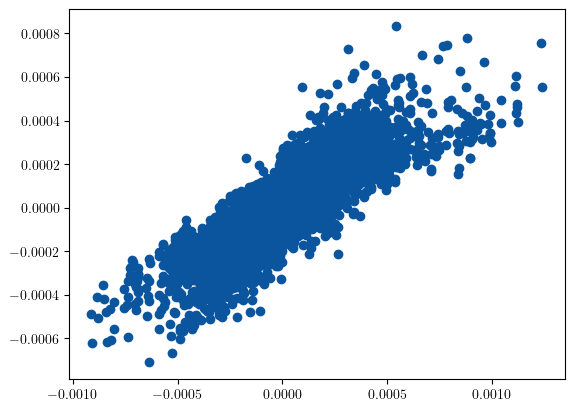

In [32]:
plt.scatter(Xi_manual.flatten()[:10000], SKT.Xi.flatten()[:10000])

<Axes: ylabel='Density'>

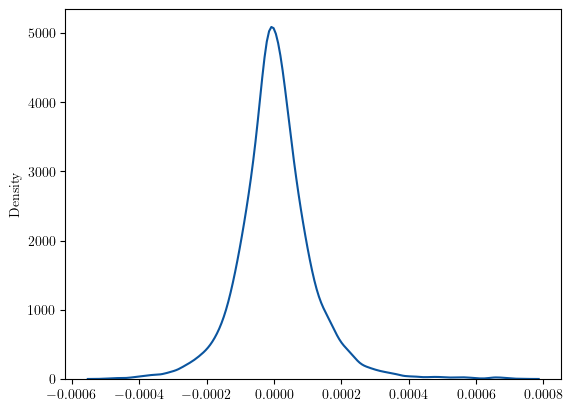

In [34]:
sns.kdeplot(Xi_manual.flatten()[:10000]-SKT.Xi.flatten()[:10000])

In [33]:
Xi_manual @ torch.inverse(SKT.Xi)

tensor([[-2.4993e+05, -2.7396e+05, -3.0206e+05,  ...,  4.1593e+03,
          2.1353e+04, -3.9422e+04],
        [-4.4464e+06, -4.9136e+06, -5.4171e+06,  ...,  1.1396e+05,
          3.8614e+05, -7.0063e+05],
        [-2.2010e+06, -2.3979e+06, -2.6418e+06,  ...,  8.2516e+03,
          1.8730e+05, -3.4316e+05],
        ...,
        [-6.0419e+05, -6.6011e+05, -7.2733e+05,  ...,  4.6768e+03,
          5.1664e+04, -9.4284e+04],
        [-3.5930e+06, -3.9676e+06, -4.3738e+06,  ...,  8.6711e+04,
          3.1191e+05, -5.6528e+05],
        [-1.9739e+06, -2.1520e+06, -2.3708e+06,  ...,  7.9243e+03,
          1.6831e+05, -3.0747e+05]], dtype=torch.float64)

## Expected value of the Kernel-PnL terms

\begin{align*}
\textup{The Kernel-PnL Terms} & \\
\Xi_{\mu} \mathbf{1} & = \mathbb{E}_{Y \sim \mu} \left[ \langle \eta_Z, \eta_Y \rangle \right] \\
& = \frac{1}{N} (K - \mathbf{11}^\top) \mathbf{1}
\end{align*}

which in our setting is `self.K_Phi`.

The the portfolio PnL is given as a linear function $\alpha$ of these,
\begin{align*}
    \mathbb{E}(V_T) & = \langle \alpha, \Xi_{\mu} \mathbf{1} \rangle \\
     & = \alpha^\top (\frac{1}{N} (K - \mathbf{11}^\top) \mathbf{1})
\end{align*}

In [14]:
N = SKT.alpha.shape[0]

kernel_pnl_terms = SKT.Xi@(torch.ones(N).to(device).double())
exp_pnl = (kernel_pnl_terms * SKT.alpha).sum()

In [15]:
print("Theoretical Expected PnL = {:.5f}".format(exp_pnl.cpu().detach().numpy()))
print("True Realised Mean = {:.2f}".format(SKT.pnl.cpu().detach().numpy()[:,-1].mean()))

Theoretical Expected PnL = 0.00039
True Realised Mean = 0.57


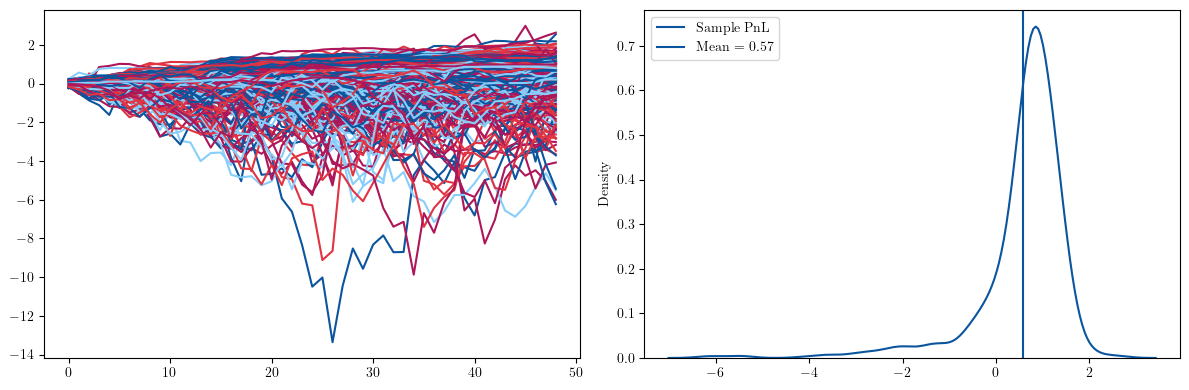

In [16]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(SKT.pnl.cpu().detach().numpy().T, label='Sample PnL');
sns.kdeplot(SKT.pnl.cpu().detach().numpy()[:,-1], ax=ax[1], label='Sample PnL');
ax[1].axvline(x = SKT.pnl.cpu().detach().numpy()[:,-1].mean(), label = "Mean = {:.2f}".format(SKT.pnl.cpu().detach().numpy()[:,-1].mean()))
ax[1].legend()
fig.tight_layout()

## Variance of the PnL

\begin{align*}
    \textup{Var}(V_T)&  = \langle \alpha, \Omega_{\mu} \alpha \rangle
\end{align*}
where
\begin{align*}
     \Omega_{\mu} \alpha =  \Xi_{\mu}^{\circ 2} \alpha - \langle \Xi_{\mu} \mathbf{1}, \alpha \rangle \Xi_{\mu} \mathbf{1}
\end{align*}
and 
\begin{align*}
    \Xi_{\mu} = \frac{1}{N} (K - \mathbf{11}^\top)
\end{align*}

Therefore, 
\begin{align*}
    \textup{Var}(V_T) = \alpha^\top \left[ \frac{1}{N^2} (K - \mathbf{11}^\top) (\textup{Id} - \frac{1}{N}\mathbf{11}^\top) (K - \mathbf{11}^\top) \right] \alpha
\end{align*}

In [17]:
var_ker = (SKT.Xi @ ((torch.eye(N) - torch.ones(N, N)/N).to(device).double()) @ SKT.Xi)
var_pnl = SKT.alpha.unsqueeze(0) @ var_ker @ SKT.alpha.unsqueeze(-1)
theoretical_terminal_SR = exp_pnl / np.sqrt(var_pnl)

In [18]:
var_pnl

tensor([[6.2205e-10]], dtype=torch.float64)

### Theoretical Ratio of

$$
\frac{\mathbb{E}(V_T)}{\sqrt{\textup{Var}(V_T)}}
$$

In [19]:
print("Theoretical Expected Ratio = {:.5f}".format(theoretical_terminal_SR.item()))
print("True Realised Ratio = {:.2f}".format(SKT.pnl.cpu().detach().numpy()[:,-1].mean() / SKT.pnl.cpu().detach().numpy()[:,-1].std()))

Theoretical Expected Ratio = 15.49102
True Realised Ratio = 0.59


# Comparison with Sig-Trader

In [20]:
target_vol = SKT.pnl.diff(dim=-1).std().item()
order = 3
dim = 1

ST = SigTrader(dim=dim, order=order)
ST.fit(sample_path = asset_sample_data, order=order, fast_solution=True);
ST.backtest(path=asset_sample_data, lin_func=ST.l, sample=False, verbose=False);

# Calculate Sharpe Ratios
ST_sharpe = ((torch.diff(ST.test_pnl,dim=-1).mean(-1) / torch.diff(ST.test_pnl,dim=-1).std(-1))*15.8).unsqueeze(1)

# Vol Scale PnLs
new_pnls = torch.cat([torch.ones(ST.test_pnl.shape[0],1),(torch.diff(ST.test_pnl, dim=1)*target_vol/torch.diff(ST.test_pnl, dim=1).std()).cumsum(1)+1],dim=1)

# PnL Statistics
ST_mean_pnl = new_pnls.mean(dim=0,keepdim=True)
ST_std_pnl = new_pnls.std(dim=0,keepdim=True)

# Save strategy positions
ST_alloc = ST.position[:,:-1,:].unsqueeze(-1)

# Expected Returns & Variance
ST_mu = (ST.l @ ST.mu_sig).item()
ST_var = (((ST.l) @ ST.var_sig)[-1] @ ST.l.T).item()

The input is already batched
The input is already batched


### PnLs

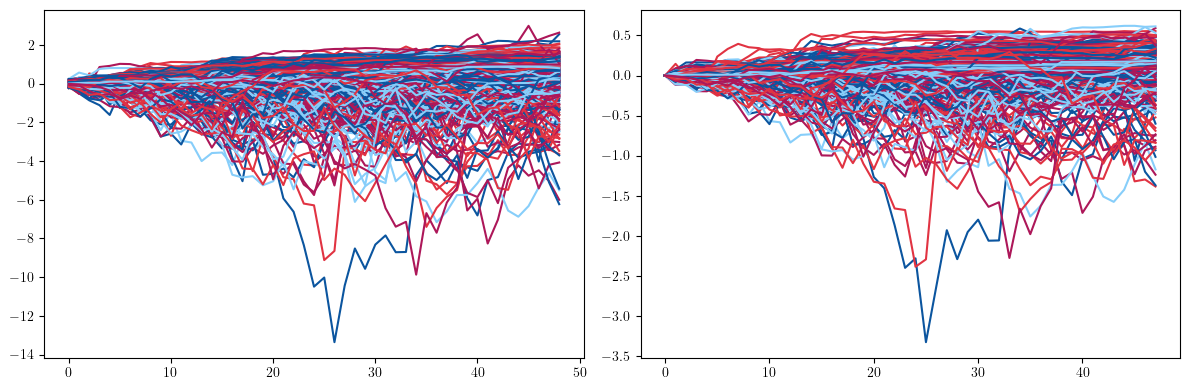

In [21]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(SKT.pnl.cpu().detach().numpy().T, label='Kernel Trader PnL');
ax[1].plot(ST.test_pnl.cpu().detach().numpy().T, label='Sig Trader PnL');
fig.tight_layout()

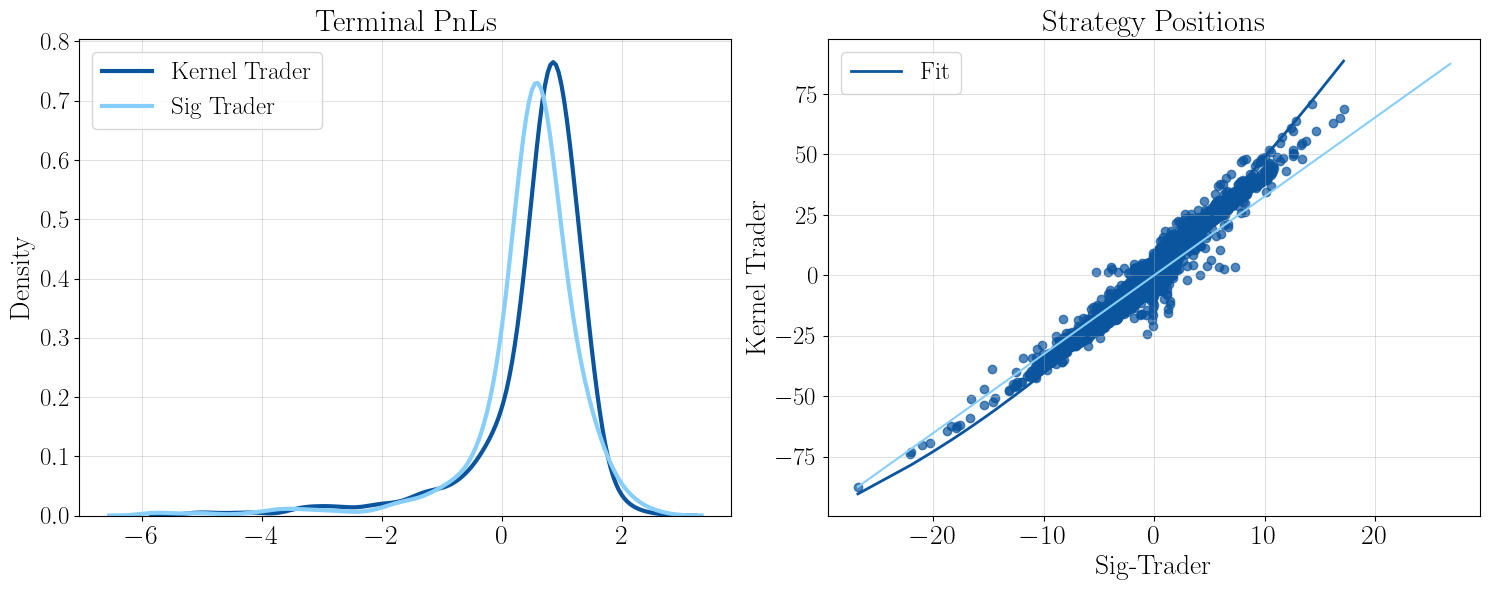

In [22]:
fig, ax = plt.subplots(1,2,figsize=(15,6))
sns.kdeplot(SKT.pnl.cpu().detach().numpy()[:,-2], ax=ax[0], label='Kernel Trader',lw=3);
sns.kdeplot(ST.test_pnl.cpu().detach().numpy()[:,-1] * (SKT.pnl.cpu().detach().numpy()[:,-2].std() / ST.test_pnl.cpu().detach().numpy()[:,-1].std()), ax=ax[0], label='Sig Trader', lw=3);
ax[0].legend(fontsize=18)
ax[0].set_title('Terminal PnLs', fontsize=22)
ax[1].scatter(ST_alloc.flatten(), SKT.position[:,1:-2].flatten(), alpha=0.7)
p = np.polyfit(ST_alloc.flatten(), SKT.position[:,1:-2].flatten(), deg=2)
y_fit = np.polyval(p, ST_alloc.flatten())
sns.lineplot(x=ST_alloc.flatten(), y=y_fit, label="Fit",ax=ax[1],linewidth=2)
ax[1].plot(np.linspace(ST_alloc.flatten().min(), -ST_alloc.flatten().min(), 100), np.linspace(SKT.position[:,1:-2].flatten().min(), -SKT.position[:,1:-2].flatten().min(), 100), color="lightskyblue")
ax[1].legend(fontsize=18)
ax[1].set_xlabel("Sig-Trader", fontsize=18)
ax[1].set_ylabel("Kernel Trader", fontsize=18)
ax[1].set_title('Strategy Positions', fontsize=22)
for i in range(2):
    ax[i].tick_params(axis='x', labelsize=20)
    ax[i].tick_params(axis='y', labelsize=18)
    ax[i].yaxis.label.set_size(20)
    ax[i].xaxis.label.set_size(20)
    ax[i].grid(alpha=0.4, linewidth=.7)
fig.tight_layout()
# plt.savefig('outputs/SK_vs_ST_OU.pdf')

## Ratios

In [42]:
print(ST_mu / np.sqrt(ST_var))
normalised_terminal_ST_pnls = ST.test_pnl.cpu().detach().numpy()[:,-1] * (SKT.pnl.cpu().detach().numpy()[:,-2].std() / ST.test_pnl.cpu().detach().numpy()[:,-1].std())
print(normalised_terminal_ST_pnls.mean() / normalised_terminal_ST_pnls.std())

0.5446425882893852
0.535846832410842


In [43]:
print(SKT.pnl.cpu().detach().numpy()[:,-2].mean() / SKT.pnl.cpu().detach().numpy()[:,-2].std())

0.6010277095372198


In [149]:
SKT.Phi.shape

torch.Size([700, 700, 50, 1])